# Mechanistic Interpretability of 5 digit addition - an experiment & learning experience

A few months ago, I came across the article [A Mechanistic Interpretability Analysis of Grokking](https://www.alignmentforum.org/posts/N6WM6hs7RQMKDhYjB/a-mechanistic-interpretability-analysis-of-grokking) by _Neel Nanda_, where he figures out the inner workings of a small Transformer-based neural network that does modular addition. I was fascinated that there were people out there who are not only _trying_ to understand how AI actually works, but in fact also _succeeding_! I've wanted to learn more about it ever since, and recently finally found some time.


Since then, Neel has turned the article into [a paper](https://arxiv.org/abs/2301.05217), published a [code repo](https://github.com/mechanistic-interpretability-grokking/progress-measures-paper) (which will be our starting point in this article), and done other interesting work, including [exploring the emergent world model](https://www.neelnanda.io/mechanistic-interpretability/othello) of a GPT-like NN that plays Othello, a simple board game (another amazing article that I strongly recommend reading, we'll be using some of the insights later). In all his work, he also outlines a lot of open questions and potential future work, including another simple 1-layer transformer that adds 5-digit integers, which we'll explore here.

This article is to a large degree a _research report_ of my exploration of the _mechanistic interpretability_ of a _5 digit addition_ transformer. I'm a complete newbie when it comes to AI, NNs and Transformers, and while I've read a few "Understanding How Transformers Work" articles, nothing beats actually poking a real, ~~living~~ working transformer model and trying to figure out how it works. However, there are no groundbreaking results and I haven't (yet!) figured out how it actually works, but I've nevertheless learned a lot and had tons of fun.

## 1. Training the model

We start from [Neel's codebase](https://github.com/mechanistic-interpretability-grokking/progress-measures-paper/blob/main/Non_Modular_Addition_Grokking_Tasks%20(1).ipynb), which implements
the _"5 digit addition"_ task (described in appendix `D.3` of his paper [Progress measures for grokking via mechanistic interpretability](https://arxiv.org/abs/2301.05217) - see figures on page 30).


Unfortunately, I couldn't reproduce the "grokking" results that Neel observed on _finite_ training data, so I experimented with the _infinite_ training data version. Still, we can observe discrete phase shifts in
total loss when the model learns to add specific digits, which I expect is somewhat similar to _"grokking"_. In any case, the first step is understanding how the model actually works, for which we'll be using the
fully trained model(s).


To train the models, I'm using a `g5.xlarge` AWS instance with A10 NVIDIA GPU, which you can buy for about $0.3 / hour (make sure to use _spot_ instances in `us-east-1` region!). It could all be done for free on Google Colab, but I personally still haven't gotten used to the Colab UX and prefer pure Jupyter. It's also possible to train the model on a CPU, my 2022 M2 MacBook Air takes about 2min 20s to train a large (`d_model=512 d_mlp=2048`) model for 3000 epochs; the `g5` instance takes about 15 seconds. MacBooks also provide their own integrated GPUs which PyTorch claims to support (the `mps` device) but loading GPU-trained weights doesn't work (or rather, it _works_ but produces _wrong_ results, might be some binary incompatibility issue).


> **setting up an AWS instance** - takes less than 10 minutes
> ```bash
> curl --ssl-reqd -sLo mambaforge.sh "https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-$(uname)-$(uname -m).sh"
> bash mambaforge.sh -b -p "$(pwd)/lib/mambaforge" && rm mambaforge.sh
> lib/mambaforge/bin/mamba init $(basename $SHELL) && lib/mambaforge/bin/conda config --set auto_activate_base false && exec $SHELL --login
> mamba create -n dev && mamba activate dev
> mamba install --yes -c pytorch -c nvidia -c conda-forge -c defaults \
>   pandas numpyro jupyterlab tqdm matplotlib numba pyarrow \
>   ipywidgets boto3 lxml beautifulsoup4 flask scikit-learn scipy \
>   sympy dash psycopg2 sqlalchemy bokeh seaborn statsmodels altair \
>   xarray arviz corner einops requests pytorch-cuda pytorch torchvision \
>   torchaudio torchtext torchdata spacy ipympl \
>   pytorch-cuda=11.8         # optional, only of you want CUDA / GPU support in PyTorch
> jupyter labextension disable '@jupyterlab/apputils-extension:announcements'    # disable spam
> ```

In [1]:
from mech_int.tom_utils import *
sns.set()
plt.rcParams['figure.figsize'] = (15, 3)

<Axes: >

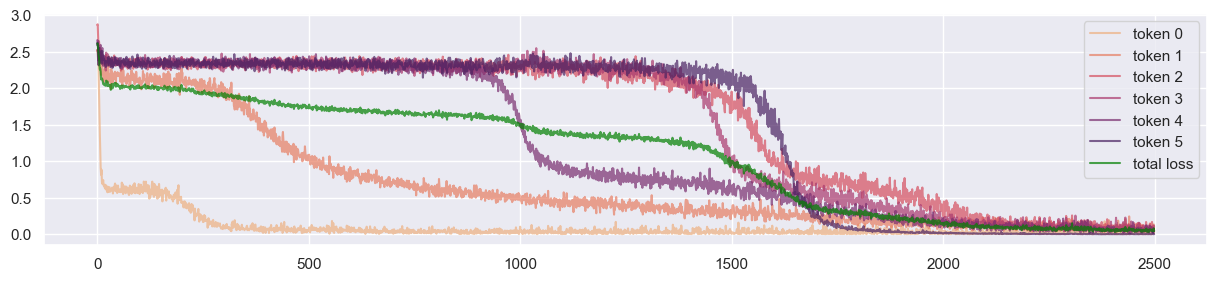

In [2]:
pd.DataFrame(load(d_model=512, d_mlp=2048)['per_token_losses_list'][:2500]).rename(columns=lambda i: f'token {i}').plot(alpha=0.7, cmap='flare')
pd.Series(load(d_model=512, d_mlp=2048)['train_loss'][:2500], name='total loss').plot(color='green', legend=True, alpha=0.7)

By plotting the per-token losses, we get a graph very similar to _Figure 29_ in Neel's paper.

- we see that the loss for token 0 drops very rapidly - this makes sense because token 0 is the _"carry"_ digit of 5-digit addition, which can only be 0 and 1.
- the model starts learning token 1 (the $10^5$ digit) next; I'm not exactly sure why, but this happens consistently across training runs; one hypothesis that the model gains extra information from having learned
  the first (carry) digit, namely "will summing up these two digits overflow" (0 -> no, 1 -> yes)
- then, there's a long gap between learning the next digit; this too is a consistent feature of different training runs
- next, the model starts learning the rest of the digits; there's no real pattern, and different models learn digits in different sequence
- the last token (the unit $10^0$ digit) usually has the steepest loss curve; this makes sense, as that's the only token that contains the _entire_ information (no need to add the _carry_ bit of the next digit);
  it's surprising that the model doesn't learn it straight after token 0 (although sometimes the model learns it _sooner_)

## 2. Training smaller models

In his paper, Neel trains a _huge_ model (for "toy model" standards) - a 1-layer transformer with 512-dimensional token encoding & transformer (4 attention heads, 128 dimensions per head) and 2048-dimensional MLP.

Can we achieve the same (or similar) results with a smaller model? This might be useful for 2 reasons - (1) a smaller model might be easier to analyse, and (2) comparing a large and a small model might yield interesting insights.

<Axes: title={'center': 'accuracy'}>

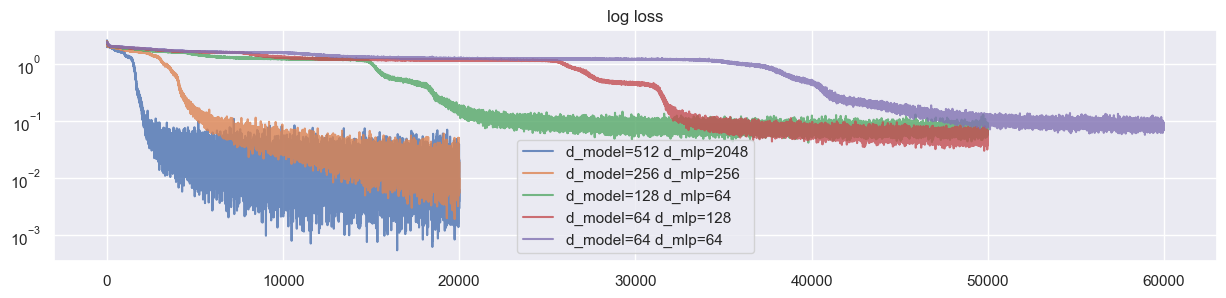

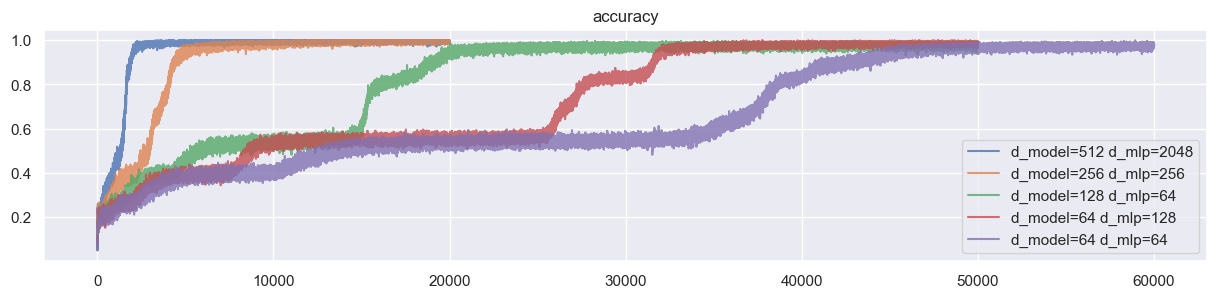

In [3]:
MODELS = [(512, 2048), (256, 256), (128, 64), (64, 128), (64, 64)]
pd.concat({f'{d_model=} {d_mlp=}': pd.Series(load(d_model=d_model, d_mlp=d_mlp)['train_loss']) for d_model, d_mlp in MODELS}, axis='columns').plot(alpha=0.8, logy=True, title='log loss')
pd.concat({f'{d_model=} {d_mlp=}': pd.Series(load(d_model=d_model, d_mlp=d_mlp)['accuracy']) for d_model, d_mlp in MODELS}, axis='columns').plot(alpha=0.8, title='accuracy')

We can see that smaller models take longer (_way_ longer) to train, and achieve worse cross-entropy loss, but reach almost the same level of accuracy.

(**Note:** training the smallest model `d_model=64 d_mlp=64` is somewhat fiddly - sometimes the model _never_ (well, in `100_000` epochs) learns some digits - need to change the `seed` to make it work.)

An interesting insight is that the `d_model=128 d_mlp=64` model trains much faster than `d_model=64 d_mlp=128`, suggesting that attention is more important for learning this task than the MLP layer.

In [4]:
pd.DataFrame([{'d_model': d_model, 'd_mlp': d_mlp, 'epochs': (data := load(d_model=d_model, d_mlp=d_mlp))['epoch'] + 1, 'loss': data['train_loss'][-1], 'accuracy': data['accuracy'][-1], 'parameters': sum(t.numel() for t in data['model'].values())} for d_model, d_mlp in MODELS])

,d_model,d_mlp,epochs,loss,accuracy,parameters
0,512,2048,20000,0.006241,0.997396,3169092
1,256,256,20000,0.009837,1.000000,404292
2,128,64,50000,0.070821,0.989583,87556
3,64,128,50000,0.061643,0.976562,35844
4,64,64,60000,0.072303,0.981771,27588


However, debugging a 30k-parameter model is about as intimidating as debugging a 3M-parameter model. Can we reduce this further?

I started with trying to remove just the bias term of the MLP; it turns out that the existing models barely use it, we don't even need to retrain the model!

In [5]:
tokens = get_tokens(2**13)

In [6]:
model = load_model(d_model=64, d_mlp=64)
print(get_accuracy(model, tokens))
model.state_dict()['blocks.0.mlp.b_in'][:] = 0
model.state_dict()['blocks.0.mlp.b_out'][:] = 0
print(get_accuracy(model, tokens))

creating new model d_model=64 d_mlp=64 d_head=16 num_layers=1 num_heads=4 output_proj=True mlp_bias=True resid_attn=True resid_mlp=True
0.9762166341145834
0.9719645182291666


Then, I was looking at the implementation of the Transformer and noticed that the _"output projection"_ matrix of the Attention layer (denoted as `W_O`) is redundant, since it is immediately followed by another matrix multiplication at
the beginning of the MLP layer, so I tried removing it and instead simply concatenating the outputs of 4 attention heads. The model still trained successfully, sometimes it just took a little bit longer.

Later I realized that `W_O` matrix isn't actually redunant, since it projects the results of the attention block back into the _residual stream_. Residual (skip) connections make large transformers (and other NN architectures) work much better, since they add an (implicit) inductive bias of preserving the input information as it flows between the layers, making each layer just slightly modify this information in an additive manner.

So I removed the residual connections as well, and the model actually trained better! (Hypothesis: the residual stream is less important in 1-layer Transformers, as all information processing happens immediately.) In the end, I was
left with a "tiny" Transformer-like model with `23364` that _worked_.

<Axes: title={'center': 'loss d_model=64 d_mlp=64'}>

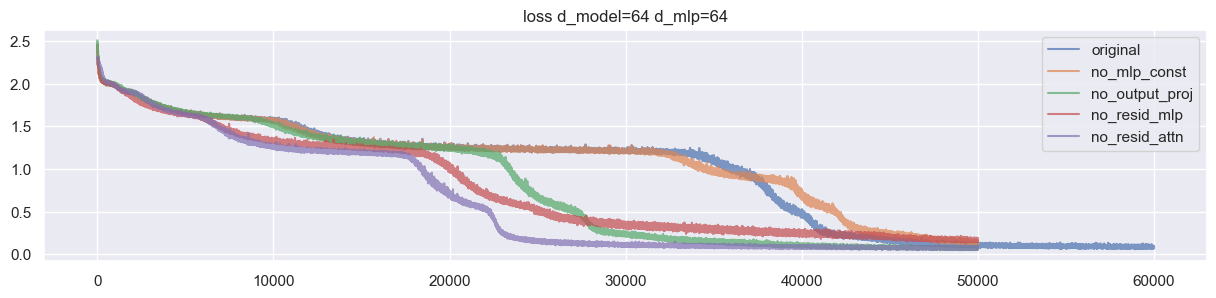

In [7]:
pd.concat({
  'original': pd.Series(load(d_model=64, d_mlp=64)['train_loss']),
  'no_mlp_const': pd.Series(load(d_model=64, d_mlp=64, mlp_bias=False)['train_loss']),
  'no_output_proj': pd.Series(load(d_model=64, d_mlp=64, mlp_bias=False, output_proj=False)['train_loss']),
  'no_resid_mlp': pd.Series(load(d_model=64, d_mlp=64, mlp_bias=False, output_proj=False, resid_mlp=False)['train_loss']),
  'no_resid_attn': pd.Series(load(d_model=64, d_mlp=64, mlp_bias=False, output_proj=False, resid_mlp=False, resid_attn=False)['train_loss']),
}, axis='columns').plot(alpha=0.7, title='loss d_model=64 d_mlp=64')

## 3. Visualising attention

But that's still way too big for any kind of manual analysis, so... I tried another route.

I've often seen different visualisations of the _attention_ mechanism in GPT-like models. The idea is to show which information in the context influences the current prediction the most, which sounds useful if trying to understand how the model works.

creating new model d_model=256 d_mlp=256 d_head=64 num_layers=1 num_heads=4 output_proj=True mlp_bias=True resid_attn=True resid_mlp=True
02093 + 02113 = 004206 


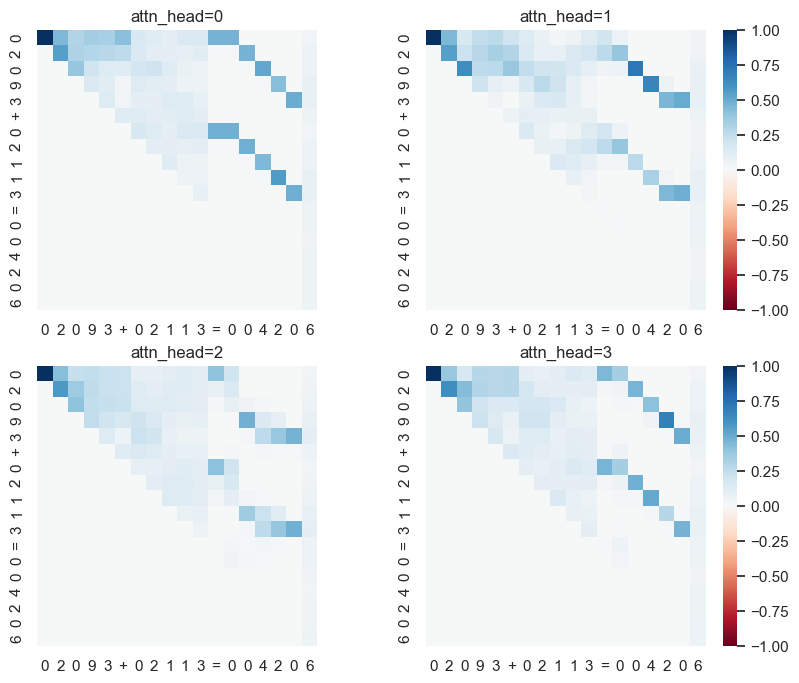

In [8]:
model = load_model(d_model=256, d_mlp=256)
show_attn(model, 2093, 2113, plotly=False)

It took me a while staring at these graphs to understand what's actually going on. First, I needed to understand the details of both the transformer implementation, and the training code. One of the crucial advantages of the _Transformer_ architecture (compared to e.g. RNNs) is that despite operating on _sequences_, it can be trained _in parallel_. That means that we're training it on all steps of the sequence _at once!_ (This is in addition to other forms of parallelism, namely batching.)

But it's easiest understood if we ignore parallelism and think about what happens with a _single_ token. We'll take `token[15]`, the third token from the right, `2` in the example above. The _Attention_ layer transforms the vector embedding of this token
into 2 other vectors, the _query_ and the _value_ vectors. It then multiplies the _query_ vector with the _key_ vectors belonging to _all_ the tokens, including itself and the tokens following it. The result is then _masked_ to zero out the contributions of
tokens _following_ `token[15]`, and the resulting vector is (after normalization) used as _weights_ to calculate the weighted average
of the _value_ vectors.

So the result of the _Attention_ layer for `token[15]` is some weighted average of the _value_ vectors of itself and all tokens
preceding it. The resulting vector is then passed through the MLP layer, and then finally transformed into a list of "probabilities"
for each of the resulting digits.

Understanding how the loss is calculated is crucial for understanding the above attention graphs. The output corresponding to
`token[15]` is optimised to be the probabilities of the _next_ token, `token[16]`. So, we can see that to predict `token[16]` (i.e.
during processing of `token[15]`), attention heads 0 and 3 are focusing on input tokens `token[3]` and `token[9]`, whereas attention
head 2 is focusing on tokens `token[4]` and `token[10]` - as if the former two were adding up digits, while the latter was
accounting for the _carry_ bit of the addition.

**Note:** A lot of my time and effort so far has been spent not only on trying to understand how the models I trained _work_, but also
writing code to make such analysis easier, in particular different kinds of visualisations that highlight certain patterns. For example, I spent a lot of time making the above attention graphs interactive using Plotly, so that you can hover over different cells
with your mouse and get information about the inputs and outputs. I also used Neel's advice for using a clear coloring scheme, with white always representing 0. However, interactive Plotly graphs cannot be rendered on GitHub, so I'm using
`matplotlib`/`seaborn`-based plots above.

The above example is somewhat cherrypicked but we can visualise a _general_ attention pattern using `std` and `mean` over a large sample of inputs. Here, we use the framework developed by Neel to inspect intermediate values ("activations") of the NN.

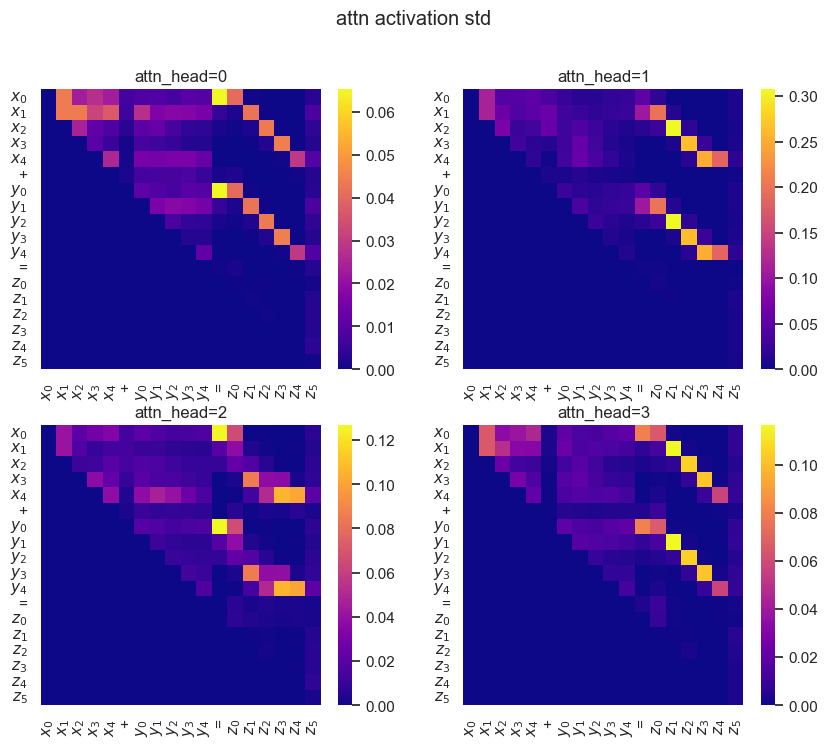

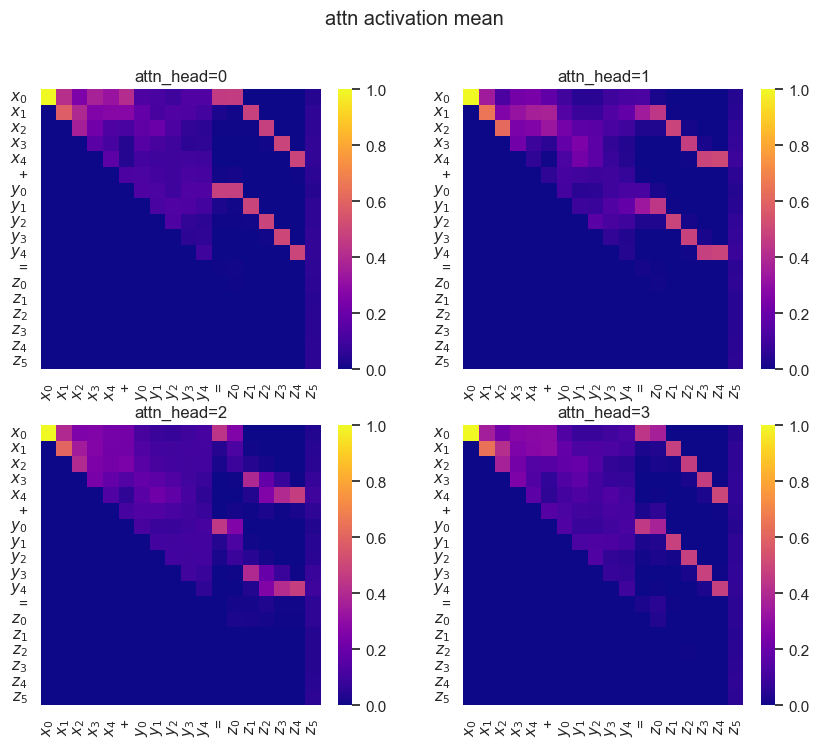

In [9]:
cache = {}
model.cache_all(cache)
with th.inference_mode():
  logits = model(tokens).detach().cpu().to(th.float64)
model.remove_all_hooks()

labels = [f'$x_{i}$' for i in range(5)] + ['+'] + [f'$y_{i}$' for i in range(5)] + ['='] + [f'$z_{i}$' for i in range(6)]
plot_attn(cache['blocks.0.attn.hook_attn'].numpy().std(axis=0), labels=labels, color_palette='plasma', color_center=False, plotly=False, title='attn activation std')
plot_attn(cache['blocks.0.attn.hook_attn'].numpy().mean(axis=0), labels=labels, color_palette='plasma', color_center=False, plotly=False, title='attn activation mean')

Here, I use a different color scheme to avoid confusion. Also, note that scaling is different for each subfigure, in particular the
attention pattern for head 0 is much more uniform than other heads. 